In [44]:
from src.harness import architecture as arch
from src.harness import history
import src.harness.seeding as seed
from src.metrics import trial_aggregations as t_agg
from src.metrics import experiment_aggregations as e_agg

import copy
import functools
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import tensorflow as tf
from typing import Any, Dict, Callable, Generator, Iterable, List, Tuple

In [29]:
epath = os.path.join(
    os.getenv("HOME"),
    "lottery-tickets/experiments/11-04-2024/lenet_mnist_0_seed_5_experiments_1_batches_0.025_default_sparsity_lm_pruning_20241102-111614",
    "models",
    "model0",
)
print(os.listdir(epath))

['trial3', 'trial6', 'trial9', 'trial14', 'trial12', 'trial2', 'trial11', 'initial', 'trial17', 'trial16', 'trial13', 'trial5', 'trial8', 'trial10', 'trial1', 'trial4', 'trial7', 'trial0', 'trial15']


In [31]:
WeightTrackingCallback = Tuple[
    str,
    Callable[
        [
            List[np.ndarray[bool]],
            history.TrialData,
        ],
        Any,
    ],
]

def prop_weights_in_mask(
    tracking_masks: List[np.ndarray], 
    trial: history.TrialData,
) -> List[float]:
    return [
        np.sum(mask[target]) / np.sum(target) 
        for target, mask in zip(tracking_masks, trial.masks)
    ]

def layerwise_sparsity(
    masks: List[np.ndarray[bool]], 
    trial: history.TrialData
) -> List[float]:
    return [np.sum(m) / m.size for m in trial.masks]

def trace_weights_over_time(
    tracking_masks: List[np.ndarray], 
    trials: Iterable[history.TrialData],
    callbacks: List[WeightTrackingCallback],
) -> Dict[str, np.ndarray]:
    data = {}
        
    for index, trial in enumerate(trials):
        for name, callback in callbacks:
            if data.get(name) is None:
                data[name] = []
            data[name].append(callback(tracking_masks, trial))
    return data

callbacks = [
    ("prop_target_remaining", prop_weights_in_mask),
    ("sparsity", layerwise_sparsity),
]
trial = next(history.get_trials(epath))
tracking_masks = [seed.target_magnitude(w, 0.2, 0) for w in trial.initial_weights]
results = trace_weights_over_time(tracking_masks, history.get_trials(epath), callbacks)

/tmp/ipykernel_80581/3956229282.py:17: RuntimeWarning: invalid value encountered in divide
  np.sum(mask[target]) / np.sum(target)


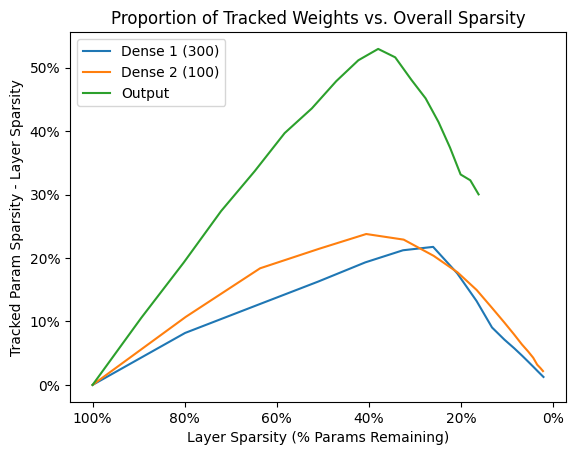

In [34]:
overall_sparsities = results["sparsity"]
tracked_sparsities = results["prop_target_remaining"]
indices = [i for i, v in enumerate(tracked_sparsities[0]) if not np.isnan(v)]

all_layers = arch.Architecture.get_model_layers("lenet")
layer_labels = [name for i, name in enumerate(all_layers) if i in indices]
sparsities = [np.array(a)[indices] for a in overall_sparsities]



diffs = []
for expected_sparsity, actual_sparsity in zip(overall_sparsities, tracked_sparsities):
    e = np.array(expected_sparsity)
    a = np.array(actual_sparsity)
    non_nan_indices = ~np.isnan(a)
    a = a[non_nan_indices]
    e = e[non_nan_indices]
    diff = a - e
    diffs.append(diff)



sparsities = np.array(sparsities) * 100
diffs = np.array(diffs) * 100


plt.figure()
plt.title("Proportion of Tracked Weights vs. Overall Sparsity")
plt.xlabel("Layer Sparsity (% Params Remaining)")
plt.ylabel("Tracked Param Sparsity - Layer Sparsity")

for index, label in enumerate(layer_labels):
    x = sparsities[:, index]
    y = diffs[:, index]
    plt.plot(x, y, label=label)
    
plt.gca().invert_xaxis()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend()
plt.show()


In [36]:
model_arch = arch.Architecture("lenet", "mnist")
model = model_arch.get_model_constructor()()
initial_weights = model.get_weights()
initial_weights[4]

array([[-8.86557996e-02, -1.29309207e-01,  1.26756608e-01,
         1.30088538e-01,  1.88331425e-01,  6.92554414e-02,
         4.45204079e-02, -2.70254314e-02,  2.21449852e-01,
        -1.92396581e-01],
       [ 1.09311253e-01, -9.83689576e-02,  1.79968297e-01,
         3.96633148e-02,  1.04930311e-01, -6.13979548e-02,
        -1.78562850e-01,  2.27159113e-01, -1.81270242e-02,
         1.67141199e-01],
       [-2.33436763e-01,  9.69620943e-02,  1.66162461e-01,
        -3.67095768e-02,  1.21859610e-01,  1.43298298e-01,
         4.47411835e-02,  7.12801814e-02,  5.74341416e-02,
         1.94307119e-01],
       [ 2.27577895e-01, -4.95135784e-04, -1.01667657e-01,
         2.23759085e-01,  1.29396349e-01, -2.26721615e-02,
        -9.84736979e-02,  2.01754928e-01, -1.23452239e-01,
         1.00324303e-01],
       [ 1.72557324e-01,  1.12317294e-01, -1.29891813e-01,
         1.29840136e-01,  1.55974329e-01, -1.73481986e-01,
         7.69444704e-02, -7.21368939e-02, -1.70555085e-01,
         2.

In [70]:
from importlib import reload

reload(seed)

weights = copy.deepcopy(initial_weights)

seed.seed_magnitude(
    weights, 
    0.2, 
    seed.Target.HIGH, 
    functools.partial(seed.scale_magnitude, factor=2)
)

0.19999574829931974
0.0
0.19996666666666665
0.0
0.199
0.0
